# Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [11]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250506_qsim' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250506_qsim


# Setup experiment hardware

In [12]:
expt_path=path+'\\data'

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data


In [14]:
curr_path = os.getcwd()
# config_file = curr_path+'\\configs\\config_rfsoc_ziqian.yml'
config_file = curr_path+'\\configs\\hardware_config_202505.yml'
config_path = config_file
print('Config will be', config_path)

exp_param_file = curr_path+'\\configs\\experiment_config.yml'
exp_param_path = exp_param_file
print('Exp Param will be', exp_param_path)

Config will be C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Exp Param will be C:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [15]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [16]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab

In [17]:
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [18]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x2c7eabf0f10; not connected; for PYRO:obj_60f1dbe4d66e49e4a42ce8f10a5bd4b8@192.168.137.101:35093>


In [19]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

# Choose experiment name

In [20]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
# if expts_path not in sys.path:
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'C:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'C:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

# Qsim

## Initial random try

In [24]:
import multimode_expts.experiments.qsim.qsim_experiments as qsim_exp

experiment_name = 'storage_sweep'

flqSwap = qsim_exp.floquet_swap_class(
    soccfg=soc, 
    path=expt_path, 
    prefix=experiment_name, 
    config_file=config_path, 
    exp_param_file=os.path.join(curr_path, 'configs', 'qsim_exp_cfg.yml')
)

flqSwap.run_sweep( sweep_experiment_name = experiment_name)

Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8

## Sideband Ramsey

This is starting to test our channel phases: when we switch from one channel generator freq to diff freq (activating different storage swaps), does our code preserve phase coherence between the successive (partial) pulses. 

We start from a simple M1-Sx Ramsey: qubit ge, qubit ef, f0g1 to initialize man1 into |1>, then do pi/2 on the beam splitter and wait and another pi/2.

In [21]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandRamseyExperiment

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demolution_readout
imported experiments.qubit_cavity.out_and_back
imported experiments.qubit_cavity.photo_resolved_pulse_probe
imported experiments.qubit_cavity.qubit_cavity_opt
impor

  0%|          | 0/40000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00026_SidebandRamsey_M1S2.h5
Current pi pulse frequency: 3567.3497210054506
Fit frequency from I [MHz]: 0.32585507240431094 +/- 0.0009871261151399116
Suggested new pi pulse frequency from fit I [MHz]:
 	3567.1238659330465
 	3567.775576077855
T2 Ramsey from fit I [us]: 114.0946877125568
Fit frequency from Q [MHz]: 0.3250680566014805 +/- 0.0018337978091449844
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3567.124652948849
 	3567.774789062052
T2 Ramsey from fit Q [us]: 51.64005095415634


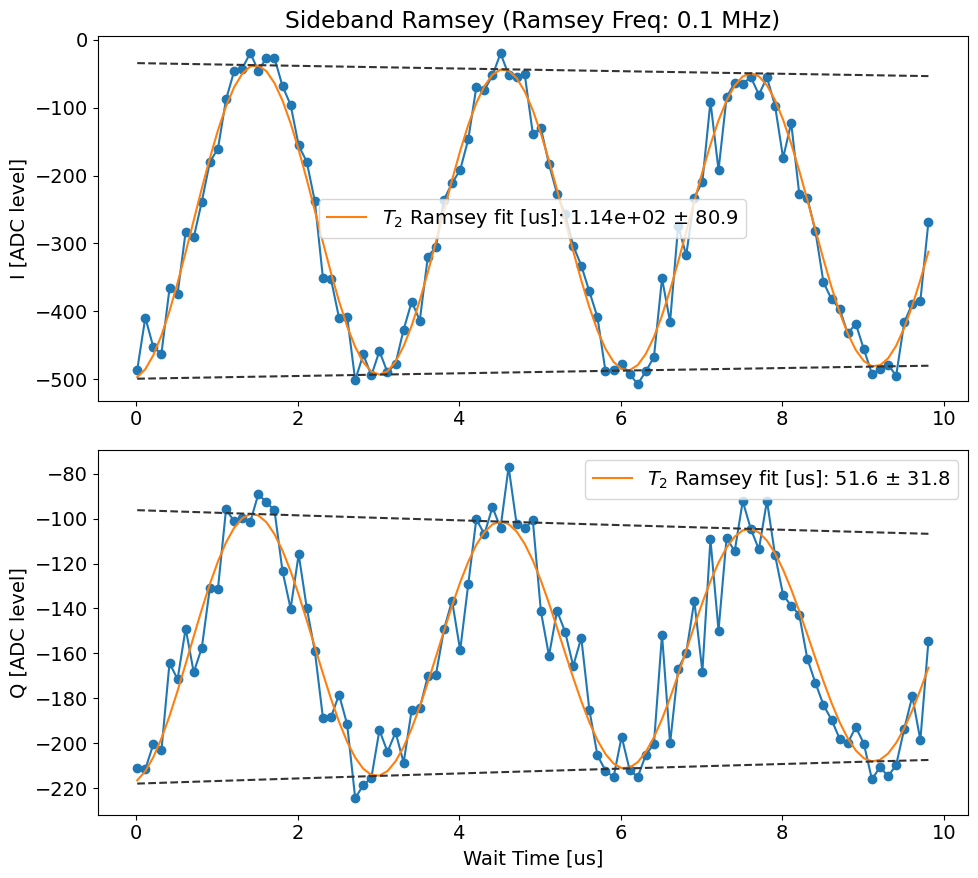

In [133]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.1,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.1, # [MHz]
    detune = 0,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 2, # storage mode number, 1 to 7
    normalize = False,
    active_reset = True,
    man_reset = True, 
    storage_reset = True, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

sbr = SidebandRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandRamsey_M1S{expt_params['stor_no']}",
    config_file=config_path,
    expt_params = expt_params,
    progress=True)

sbr.cfg.device.readout.relax_delay = [100]  # Wait time between experiments [us]
# sbr.acquire()
sbr.go(analyze=True, display=True, progress=True, save=True)

In [ ]:
0.327922332524605 # current reset version
0.32806373843420333 # without reset
0.3264759424279595 # reset with 100us wait
0.3274569103286323 # only 0 to N+1
0.328382941835013 # only -N to 0
0.327225195204317 # only 0
0.325693135972055 # n set to 30
0.32566986782848 # add 100 to m1d1

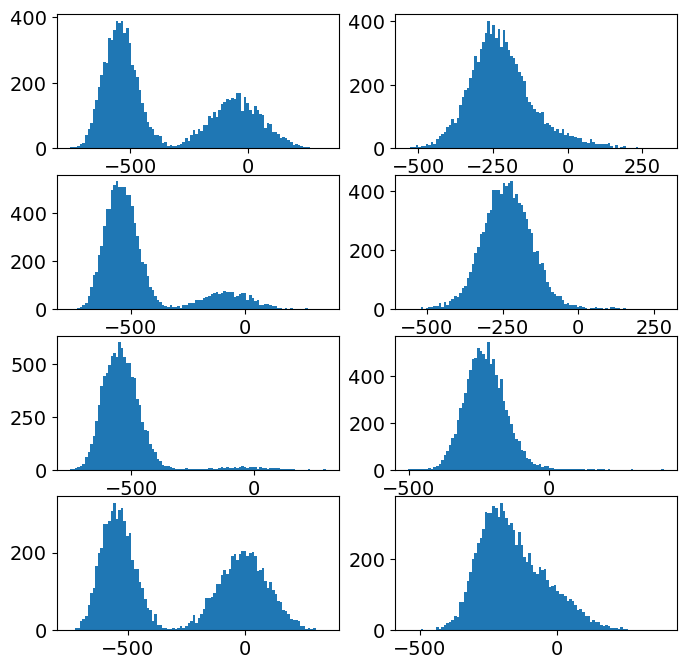

In [134]:
idata = sbr.data['idata']
idata = idata.reshape((len(idata)//4,4))

qdata = sbr.data['qdata']
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

### 2D chevron

In [57]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandChevronExperiment

In [63]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.1,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.1, # [MHz]
    detune = 0,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = False,
    # man_reset = False, 
    # storage_reset = False, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

for stor_no in range(1,8):
    expt_params['stor_no'] = stor_no
    sbr = SidebandChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandChevron_M1S{stor_no}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    # sbr.acquire()
    sbr.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S1.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S2.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S3.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S4.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S5.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S6.h5


  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_SidebandChevron_M1S7.h5


# Ramp current

In [ ]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.00032, sweeprate=0.0001)

In [ ]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.000, sweeprate=0.002)

In [ ]:
# dcflux = YokogawaGS200(address="192.168.137.148")
#     dcflux.set_output(True)
#     dcflux.set_mode('current')
#     dcflux.ramp_current(0.000, sweeprate=0.002)